In this juper lab: 

1. load the sessions
2. run the model on all sessions and make a summary figure 
3. merge the summary figure for all the sessions
    

In [449]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Spike_train import Spike_train
from spikeA.Animal_pose import Animal_pose
from spikeA.Spatial_properties import Spatial_properties
from spikeA.Neuron import Simulated_place_cell, Simulated_grid_cell
from scipy.stats import poisson
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy import stats
from scipy import ndimage
from astropy.stats import circcorrcoef
from astropy import units as u
from functions import *
from lstmModel import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [450]:
%run ../../setup_project.py
%run ../../neuronAutopi.py

%run ../../generic_plot_functions.py

projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_inter",
                                                                dataPath="/adata/projects/autopi_inter/",dlcModelPath="/adata/models")


creating myProject, an autopipy.project object
Project name: autopi_inter
dataPath: /adata/projects/autopi_inter/
dlcModelPath: /adata/models
Reading /adata/projects/autopi_inter//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [451]:
#prepareSessionsForSpatialAnalysisProject(sSessions[:],myProject.sessionList[:]) ### sSeslist >>>> sSessions

prepareSessionsForSpatialAnalysisProject(sSessions[152:154],myProject.sessionList[152:154]) ### sSeslist >>>> sSessions
#prepareSessionsForSpatialAnalysisProject(sSessions[64:67],myProject.sessionList[64:67]) ### sSeslist >>>> sSessions

Loading Animal_pose and Spike_train, sSes.ap and sSes.cg
Will load .pose.npy


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.13s/it]

Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [452]:
#for ses, sSes in tqdm(zip(myProject.sessionList[:],sSessions[:])):
for ses, sSes in tqdm(zip(myProject.sessionList[152:154],sSessions[152:154])):
#for ses, sSes in tqdm(zip(myProject.sessionList[64:67],sSessions[64:67])):
    getSearchHomingIntervals(ses, sSes)

2it [00:00, 40.60it/s]


In [453]:
%%time

fn=myProject.dataPath+"/results/cells_with_leverCells.csv"
print('loading', fn)
cells = pd.read_csv(fn)

## load the levertime press 
fn ='behavior_180_v2.csv'
print('loading', fn)

res = pd.read_csv(fn)
###
df_HDInfoSingle = pd.read_csv('df_HDInfo.csv') 


loading /adata/projects/autopi_inter//results/cells_with_leverCells.csv
loading behavior_180_v2.csv
CPU times: user 138 ms, sys: 699 µs, total: 139 ms
Wall time: 138 ms


get the session index for sessions with more than 10 FS cells


In [454]:
filtered_cells = cells[(cells['interneuron']) & (cells['mrate_RF1'] > 10)]
session_counts = filtered_cells.groupby('session').size()

# Count how many sessions have more than one FS cell meeting the criteria
num_sessions = (session_counts >= 10).sum()
sessionList = session_counts[session_counts >= 10].index.tolist()
num_sessions 

sessionList[0]
Mylists=[]
for sesName in sessionList:
    Mylists.append([sSes.name for sSes in sSessions].index(sesName)) 

In [455]:
def run_evalute_model(sSes, ses, interName,cells, ctype='fs', sigma_ifr=5): 
    # Check if there are more than 1 FS cells in the session
    FS_count = cells[(cells.interneuron) & (cells.mrate_RF1 > 10) & (cells.session == sSes.name)].shape[0]
    if FS_count >= 1:
               
        train_dataset, test_dataset, train_data_loader, test_data_loader, myDict, config= get_test_training_datas_oneSession(sSes, ses, cells,interName, ctype= 'fs', sigma_ifr= 5, maxDistance= 18, rotationType="none")
        
        ### get my model 
        device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
        model = LSTM(config["n_cells"], config["hidden_size"], config["num_layers"], config["num_outputs"],config["seq_length"],device=device).to(device)
        #print("Device available:", device)

        #optimizer = torch.optim.Adam(model.parameters(),lr=config["learning_rate"])
        optimizer = torch.optim.SGD(model.parameters(),lr=config["learning_rate"])
        loss_fn = torch.nn.MSELoss() # 
        model.train()


        ### train the model 
        df, best_model_state = training_loop(n_epochs=config["num_epochs"],
                     optimizer=optimizer,
                     model = model,
                     loss_fn = loss_fn,
                     train_data_loader=train_data_loader,
                     test_data_loader=test_data_loader, #changed to look at prediction in training dataset
                     config=config,
                     device = device,
                     verbose=False)
    
        mse_test, outputs_test, labels_test = get_labels_and_outputs_mse(model, test_data_loader, device)
        mse_train, outputs_train, labels_train = get_labels_and_outputs_mse(model, train_data_loader, device)

        myMetrics= {'session': sSes.name,
                   'df': df, 
                   'mse_test': mse_test, 
                   'outputs_test': outputs_test, 
                    'labels_test': labels_test, 
                    'mse_train': mse_train, 
                    'outputs_train': outputs_train,
                    'labels_train':labels_train,
                    'config': config
               }
        
    else:
        myMetrics=np.nan
    return myMetrics

def plot_summary_model_one_session(gs, sesName, df, Angle_test, Angle_test_pred, Angle_train, Angle_train_pred, shuffle, n_epochs, iteration ):
    
    #########################################
    ## plo the epochs and  test/training loss
    #########################################
    ax= fig.add_subplot(gs[0,0])
    ax.plot(df.epochs, df.train_loss, label= 'Train.')
    ax.plot(df.epochs, df.test_loss, label= 'Test')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc= 'center')
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss values')
    ax.set_title('{} \n epochs:{} ' .format(sesName, n_epochs), fontsize=9)
    ax.legend(loc='upper center', bbox_to_anchor=(0.9, 1.0), fancybox=True, shadow=True, fontsize=7)
    
    ##################################
    ## plot angle and pred. angle in test and training datasets:
    ###################################
    #Angle_test = np.arctan2(labels_test[:,0], labels_test[:,1])
    #Angle_test_pred = np.arctan2(outputs_test[:,0], outputs_test[:,1])
    
    ax= fig.add_subplot(gs[0,1])
    ax.scatter(Angle_train, Angle_train_pred, s= 0.1)
    ax.set_xlabel('Angles ')##
    ax.set_ylabel('predicted Angles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    r,p= pearsonr(Angle_train, Angle_train_pred)
    circr= abs(circcorrcoef(Angle_train, Angle_train_pred)) 
    ax.set_title('Train \n r:{:.2f} \n cir.r: {:.2f}'.format(r,circr ), fontsize=9)
    # plot the identity line
    ax.plot([min(Angle_train), max(Angle_train)], [min(Angle_train_pred), max(Angle_train_pred)], color='red', label=f'Iden. line')
    
    ax= fig.add_subplot(gs[0,2])
    ax.scatter(Angle_test, Angle_test_pred, s= 0.1)
    ax.set_xlabel('Angles ')##
    ax.set_ylabel('predicted Angles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(Angle_test, Angle_test_pred)
    circr= abs(circcorrcoef(Angle_test, Angle_test_pred))
    ax.set_title('Test \n r:{:.2f}  \n cir.r: {:.2f}'.format(r, circr), fontsize=9)
    # plot the identity line
    ax.plot([min(Angle_test), max(Angle_test)], [min(Angle_test_pred), max(Angle_test_pred)], color='red', label=f'Iden. line')
    
    
    ## plot the model against the shuffle value 
    ax= fig.add_subplot(gs[0,3])
    ax.hist(shuffle.r_test)
    threshold= np.percentile(shuffle.r_test,95)
    ax.axvline(x=threshold, color='black', linestyle='--', linewidth=2, label='thr.')
    r_original,p= pearsonr(Angle_test, Angle_test_pred)
    ax.axvline(x=r_original, color='red', linestyle='-', linewidth=2, label='ori. r')
    ax.set_title(f'Test \n iteration:{iteration}, n_fs:{shuffle.df.iloc[0].n_cells.iloc[0]}', fontsize=9)
    ax.set_xlabel('Pearson r ')##
    ax.set_ylabel('Count')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper center', bbox_to_anchor=(1.7, 1.0), fancybox=True, shadow=True)
    
    #####################################################
    ### plot the 2d density plot for angle vs pred. angle 
    #####################################################

    ax= fig.add_subplot(gs[1,0])
    sns.kdeplot(x=Angle_test, y=Angle_test_pred, cmap="viridis", fill=True)
    ax.set_xlabel('Angles (pi)', fontsize=9)##
    ax.set_ylabel(' Predicted Angles (pi)', fontsize=9)##
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ###########
    ## check if i can get the location of the animal around the lever and compare it with the real location
    ###############
    x =  np.cos(Angle_test)
    y = np.sin(Angle_test)
    x_ =  np.cos(Angle_test_pred)
    y_ = np.sin(Angle_test_pred)

    ax= fig.add_subplot(gs[1,1])
    ax.scatter(x[10:50],y[10:50], s= 0.7, c= 'darkgray', label='data')
    ax.scatter(x_[10:50]+0.04,y_[10:50]+0.11, s= 0.8, c= 'red', label= 'predicted data')
    ax.axis('off')
    r,p= pearsonr(x, x_)
    ax.set_title(f'r:{r:.2f}, Ex.1', fontsize= 9)

    ax= fig.add_subplot(gs[1,2])
    ax.scatter(x[60:100],y[60:100], s= 0.7, c= 'darkgray', label='data')
    ax.scatter(x_[60:100]+0.04,y_[60:100]+0.11, s= 0.8, c= 'red', label= 'pred. data')
    ax.axis('off')
    r,p= pearsonr(x, x_)
    ax.set_title(f'r:{r:.2f}, Ex.2', fontsize= 9)
    
    ax= fig.add_subplot(gs[1,3])
    ax.scatter(x[110:150],y[110:150], s= 0.7, c= 'darkgray', label='data')
    ax.scatter(x_[110:150]+0.04,y_[110:150]+0.11, s= 0.8, c= 'red', label= 'pred. data')
    ax.axis('off')
    r,p= pearsonr(x, x_)
    ax.set_title(f'r:{r:.2f}, Ex.3', fontsize= 9)
    ax.legend(loc='upper center', bbox_to_anchor=(1.7, 1.0), fancybox=True, shadow=True)


In [458]:
ses= myProject.sessionList[152]
sSes= sSessions[152]

ctype= 'fs'
sigma_ifr= 5
interName= 'atLever_light'
## RUN THE MODEL
myMetrics = run_evalute_model(sSes, ses, interName,cells, ctype=ctype, sigma_ifr=sigma_ifr)


Plot some example from the model and compare it with shuffled value 

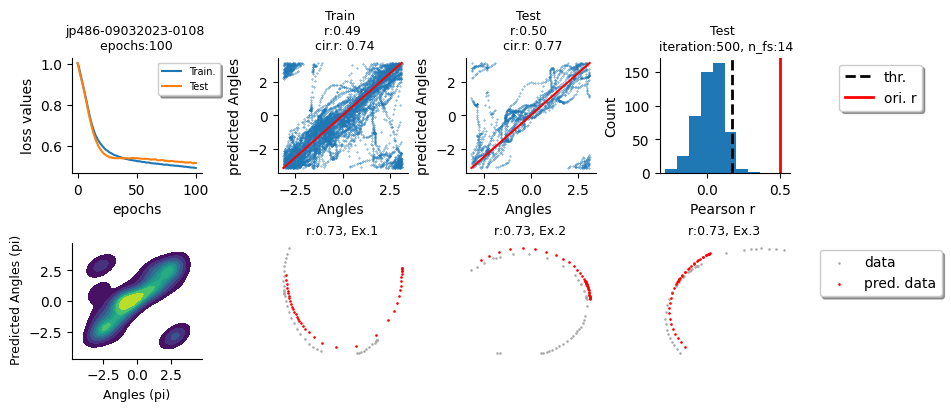

In [459]:
col = 6
row = 2
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

shuffled_directory= '/adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/500_shuffle/'
fn= f'{shuffled_directory}{sSes.name}_{interName}_shuffled_values.pkl'
shuffle= pd.read_pickle(fn)

Angle_train = np.arctan2(myMetrics['labels_train'][:,0], myMetrics['labels_train'][:,1])
Angle_train_pred = np.arctan2(myMetrics['outputs_train'][:,0], myMetrics['outputs_train'][:,1])

Angle_test = np.arctan2( myMetrics['labels_test'][:,0], myMetrics['labels_test'][:,1])
Angle_test_pred = np.arctan2(myMetrics['outputs_test'][:,0], myMetrics['outputs_test'][:,1])

plot_summary_model_one_session(gs,sSes.name, myMetrics['df'], Angle_test, Angle_test_pred, Angle_train, Angle_train_pred, shuffle, n_epochs= 100, iteration= 500 )

## Create summary figure for each session

Make a function that :

 + go through each session, load the shuffled_df 
 + load the original model for all the sessions 
 
 
access the shuffled_df for each session on:



## 500_shuffled

In [444]:
from matplotlib.backends.backend_pdf import PdfPages
import os
directory= '/adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/500_shuffle/'

file_names = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
SessionList= [f.split('_')[0] for f in file_names]
SesIndxs= [[sSes.name for sSes in sSessions].index(sesName) for sesName in SessionList ]

In [302]:
for i, (sesind, f) in enumerate(zip(SesIndxs[:], file_names[:])): 
    #print(i, sesind)
    sSes= sSessions[sesind]
    ses= myProject.sessionList[sesind]
    
    mymodel= allSessions_df[allSessions_df.session== sSes.name]
    fn= directory + f
    shuffle= pd.read_pickle(fn)
  

    col = 4
    row = 2
    sizePerRow, sizePerCol = 2.7, 2.7
    fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
    gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

    # Directory to save the PDF files
    output_dir = "/adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/"
    os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

    # Initialize the PDF file
    fn= sSes.name+ '_atLeverLight_500.pdf'
    pdf_file = os.path.join(output_dir, fn)
     
    with PdfPages(pdf_file) as pdf:

        plot_summary_model_one_session(gs,sSes.name, mymodel.df.iloc[0], mymodel.Angle_test.iloc[0], mymodel.Angle_test_pred.iloc[0], mymodel.Angle_train.iloc[0], 
                                          mymodel.Angle_train_pred.iloc[0], shuffle, n_epochs= 100, iteration= 500 )
        # Add the current figure to the PDF
        pdf.savefig(fig)
        plt.close(fig)  # Close the figure to free up memory

        print(f"PDF saved to {pdf_file}")

PDF saved to /adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/jp486-02032023-0108_atLeverLight_500.pdf
PDF saved to /adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/jp486-05032023-0108_atLeverLight_500.pdf
PDF saved to /adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/jp486-16032023-0108_atLeverLight_500.pdf
PDF saved to /adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/jp486-27022023-0108_atLeverLight_500.pdf
PDF saved to /adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/jp486-17032023-0108_atLeverLight_500.pdf
PDF saved to /adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/jp486-10032023-0108_atLeverLight_500.pdf
PDF saved to /adata/pr

Merge all the sessions in a single pdf file:

In [446]:
from PyPDF2 import PdfMerger
directory= '/adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/500_shuffle/'
output_file = "/adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/500_shuffle/allSessions_500_atLeverLight.pdf"

# Initialize the PdfMerger
merger = PdfMerger()

# Find all PDF files in the directory
pdf_files = [f for f in os.listdir(directory) if f.endswith('.pdf')]
pdf_files.sort()  # Sort files alphabetically (optional)

# Loop through and append each PDF to the merger
for pdf in pdf_files:
    file_path = os.path.join(directory, pdf)
    merger.append(file_path)

# Write the merged PDF to disk
merger.write(output_file)
merger.close()

from PyPDF2 import PdfReader
reader = PdfReader(output_file)
print(f"Total pages in merged PDF: {len(reader.pages)}")

Total pages in merged PDF: 22


## 100_shuffle

make the same figure for 100 shuffles : 


In [447]:
from matplotlib.backends.backend_pdf import PdfPages
import os
directory= '/adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/100_shuffle/'

file_names = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
## only the light intervals
light_files = [file for file in file_names if 'light' in file]
dark_files = [file for file in file_names if 'dark' in file]

SessionListLight= [f.split('_')[0] for f in light_files]
SessionListDark= [f.split('_')[0] for f in dark_files]

SesIndxsL= [[sSes.name for sSes in sSessions].index(sesName) for sesName in SessionListLight]
SesIndxsD= [[sSes.name for sSes in sSessions].index(sesName) for sesName in SessionListDark]

In [448]:
len(SesIndxsL)

153

In [337]:
for i, (sesind, f) in enumerate(zip(SesIndxsL[:], light_files[:])): 
    sSes = sSessions[sesind]
    ses = myProject.sessionList[sesind]

    mymodel = allSessions_df[allSessions_df.session == sSes.name]
    fn = directory + f
    shuffle = pd.read_pickle(fn)

    col = 4
    row = 2
    sizePerRow, sizePerCol = 2.7, 2.7
    fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
    gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

    # Directory to save the PDF files
    output_dir = "/adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/100_shuffle/"
    os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

    # Initialize the PDF file
    pdf_file_name = f"{sSes.name}_atLeverLight_100.pdf"
    pdf_file_path = os.path.join(output_dir, pdf_file_name)

    # Check if the PDF file already exists
    if os.path.exists(pdf_file_path):
        print(f"PDF already exists for {sSes.name}. Skipping...")
        continue

    with PdfPages(pdf_file_path) as pdf:
        # Call your plotting function
        plot_summary_model_one_session(
            gs, 
            sSes.name, 
            mymodel.df.iloc[0], 
            mymodel.Angle_test.iloc[0], 
            mymodel.Angle_test_pred.iloc[0], 
            mymodel.Angle_train.iloc[0], 
            mymodel.Angle_train_pred.iloc[0], 
            shuffle, 
            n_epochs=100, 
            iteration=500
        )
        # Add the current figure to the PDF
        pdf.savefig(fig)
        plt.close(fig)  # Close the figure to free up memory

    print(f"PDF saved to {pdf_file_path}")


PDF saved to /adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/100_shuffle/mn8599-16022022-0107_atLeverLight_100.pdf
PDF already exists for mn8599-22012022-0108. Skipping...
PDF saved to /adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/100_shuffle/jp1686-26042022-0108_atLeverLight_100.pdf
PDF saved to /adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/100_shuffle/mn8599-09022022-0107_atLeverLight_100.pdf
PDF saved to /adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/100_shuffle/mn8599-26012022-0107_atLeverLight_100.pdf
PDF already exists for jp486-02032023-0108. Skipping...
PDF saved to /adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/100_shuffle/jp452-21112022-0108_atLeverLight_100.pdf
PDF save

/tmp/ipykernel_647127/2902220964.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)


PDF saved to /adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/100_shuffle/mn8578-05122021-0108_atLeverLight_100.pdf
PDF saved to /adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/100_shuffle/jp487-07022023-0108_atLeverLight_100.pdf
PDF saved to /adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/100_shuffle/jp451-24102022-0108_atLeverLight_100.pdf
PDF saved to /adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/100_shuffle/jp1084-13042022-0108_atLeverLight_100.pdf
PDF already exists for jp499-26052023-0110. Skipping...
PDF saved to /adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/100_shuffle/mn8578-23122021-0108_atLeverLight_100.pdf
PDF saved to /adata/projects/autopi_inter/results/interneurons_dec

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

merge all the pdf files so we have a single pdf to compare everything : 


In [339]:
from PyPDF2 import PdfMerger
directory= '/adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/100_shuffle/'
output_file = "/adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/sessions_model_plot/atLeverLight/100_shuffle/allSessions_100_atLeverLight.pdf"

# Initialize the PdfMerger
merger = PdfMerger()

# Find all PDF files in the directory
pdf_files = [f for f in os.listdir(directory) if f.endswith('.pdf')]
pdf_files.sort()  # Sort files alphabetically (optional)

# Loop through and append each PDF to the merger
for pdf in pdf_files:
    file_path = os.path.join(directory, pdf)
    merger.append(file_path)

# Write the merged PDF to disk
merger.write(output_file)
merger.close()

from PyPDF2 import PdfReader
reader = PdfReader(output_file)
print(f"Total pages in merged PDF: {len(reader.pages)}")

Total pages in merged PDF: 132
